## Install dependencies

In [1]:
!pip install datasets trl peft bitsandbytes wandb accelerate transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 13.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 67.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 64.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 54.3 MB/s eta 0:00

In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
import os
import gc
import torch
import transformers
from transformers import (
    AutoModelForCausalLM, 
    AutoTokenizer, 
    TrainingArguments, 
    BitsAndBytesConfig
)
from datasets import load_dataset
from peft import (
    LoraConfig, 
    PeftModel, 
    get_peft_model, 
    prepare_model_for_kbit_training
)
from trl import DPOTrainer, setup_chat_format
import bitsandbytes as bnb

## Load the model and tokenizer

Note that we also load in a reference model. This is for completeness. If we did not provide one, the DPOTrainer will automatically create one for us

In [3]:
base_model = "meta-llama/Meta-Llama-3-8B-Instruct"
new_model = "BrevDPOLlama-3-8B"

In [4]:
# The bits and bytes config we use for quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

In [5]:
tokenizer = AutoTokenizer.from_pretrained(base_model)
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    device_map="auto",
)
# Reference model
ref_model = AutoModelForCausalLM.from_pretrained(
    base_model,
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    device_map="auto",
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
# LoRA configuration
peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['k_proj', 'gate_proj', 'v_proj', 'up_proj', 'q_proj', 'o_proj', 'down_proj']
)

## Load and format dataset

Preference datasets are a little unique as I explained above. Let's take a look

In [9]:
# Load dataset
dataset = load_dataset("Intel/orca_dpo_pairs")['train']

In [10]:
# In this notebook we use a subset of 150 samples. In order to do a full tune, you can use around 1000 or the entire dataset
# The seed allows for reproducability. If you run this notebook exactly, you will use the same 150 samples as me
dataset = dataset.shuffle(seed=42).select(range(150))

In [11]:
dataset

Dataset({
    features: ['system', 'question', 'chosen', 'rejected'],
    num_rows: 150
})

Preference datasets contain the original prompt along with `chosen` and `rejected` columns. These are our preferences. We want the model to respond in a certain way. Uncomment the cells below and tinker around to see why different answers were rejected or chosen!

In [12]:
dataset[19]['question']

'WWE star invites Conor McGregor to join WWE\nConor McGregor turned the UFC world upside down in less than 140 characters Tuesday, cryptically tweeting that he has made the decision to "retire young."\n\nI have decided to retire young.Thanks for the cheese. Catch ya\'s later.\n\nNo one really knows what McGregor means. He may have just announced his retirement at the age of 27, or perhaps McGregor is simply sharing that he doesn\'t plan to fight well into his 30s. As one of the biggest stars in sports, and at the height of his earning potential, it would seem crazy for McGregor to actually retire - but he would certainly have lucrative options outside of the octagon.\n\nMcGregor\'s Irish compatriot Becky Lynch suggested on Twitter that the UFC superstar should make the jump to professional wrestling and join WWE.\n\nMcGregor wouldn\'t be the first MMA star to transition to WWE. "The World\'s Most Dangerous Man" Ken Shamrock is the best example of a success story. Shamrock came to WWE i

In [13]:
dataset[19]['rejected']

" The article discusses the possibility of Conor McGregor, a UFC star, joining WWE. McGregor has announced his retirement from the UFC, and WWE star Becky Lynch has suggested that he should join WWE. The article explores the potential of McGregor joining WWE, including the possibility of him being a massive draw, but also notes that it would be challenging to integrate him into the WWE roster and storylines. The article also mentions other MMA stars who have transitioned to WWE, such as Ken Shamrock and Brock Lesnar. Additionally, the article suggests that McGregor's character and personality would be a major factor in any WWE storyline."

In [14]:
dataset[19]['chosen']

'This article is about the speculation surrounding UFC star Conor McGregor\'s potential retirement from the sport after his cryptic tweet hinting at "retiring young." The article discusses the suggestion made by McGregor\'s Irish compatriot Becky Lynch that he should transition from UFC to professional wrestling, specifically WWE. The possibility of McGregor joining WWE is analysed, drawing comparisons with other MMA stars who have made the switch, such as Ken Shamrock, Dan Severn, Alberto Del Rio, Shinsuke Nakamura, and Brock Lesnar.\n\nThe article addresses various factors that would need to be considered, such as McGregor\'s professional wrestling training, potential character challenges, and the scope of his involvement in WWE storylines. It concludes by contemplating the idea of McGregor taking part in occasional high-profile WWE pay-per-view events, similar to Brock Lesnar\'s approach, rather than becoming a regular main eventer.'

Now we format the dataset in order to follow the Llama3 format using the extremely helpful chat templates created by chujiezheng

In [15]:
!wget -L https://raw.githubusercontent.com/chujiezheng/chat_templates/main/chat_templates/llama-3-instruct.jinja

--2024-05-26 18:14:14--  https://raw.githubusercontent.com/chujiezheng/chat_templates/main/chat_templates/llama-3-instruct.jinja
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 935 [text/plain]
Saving to: ‘llama-3-instruct.jinja.1’

llama-3-instruct.ji 100%[===================>]     935  --.-KB/s    in 0s      

2024-05-26 18:14:15 (27.2 MB/s) - ‘llama-3-instruct.jinja.1’ saved [935/935]



In [16]:
chat_template = open('llama-3-instruct.jinja').read()
chat_template = chat_template.replace('    ', '').replace('\n', '')
tokenizer.chat_template = chat_template

In [17]:
def dataset_format(example):
    # Format system
    if len(example['system']) > 0:
        message = {"role": "system", "content": example['system']}
        system = tokenizer.apply_chat_template([message], tokenize=False)
    else:
        system = ""
    # Format instruction
    message = {"role": "user", "content": example['question']}
    prompt = tokenizer.apply_chat_template([message], tokenize=False, add_generation_prompt=True)
    # Format chosen answer
    chosen = example['chosen'] + "<|eot_id|>\n"
    # Format rejected answer
    rejected = example['rejected'] + "<|eot_id|>\n"
    return {
        "prompt": system + prompt,
        "chosen": chosen,
        "rejected": rejected,
    }

In [18]:
original_columns = dataset.column_names
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

dataset = dataset.map(
    dataset_format,
    remove_columns=original_columns,
    num_proc= os.cpu_count(),
)

Map (num_proc=12):   0%|          | 0/150 [00:00<?, ? examples/s]

In [19]:
# notice the specific llama3 tags like <|eot_id|> which show that the chat template formatting worked
dataset[19]

{'chosen': 'This article is about the speculation surrounding UFC star Conor McGregor\'s potential retirement from the sport after his cryptic tweet hinting at "retiring young." The article discusses the suggestion made by McGregor\'s Irish compatriot Becky Lynch that he should transition from UFC to professional wrestling, specifically WWE. The possibility of McGregor joining WWE is analysed, drawing comparisons with other MMA stars who have made the switch, such as Ken Shamrock, Dan Severn, Alberto Del Rio, Shinsuke Nakamura, and Brock Lesnar.\n\nThe article addresses various factors that would need to be considered, such as McGregor\'s professional wrestling training, potential character challenges, and the scope of his involvement in WWE storylines. It concludes by contemplating the idea of McGregor taking part in occasional high-profile WWE pay-per-view events, similar to Brock Lesnar\'s approach, rather than becoming a regular main eventer.<|eot_id|>\n',
 'rejected': " The articl

## Create the DPO trainer

In [20]:
import wandb

wandb.login()

wandb: Currently logged in as: ishandhanani (brevdev). Use `wandb login --relogin` to force relogin


True

In [23]:
training_args = TrainingArguments(
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    max_steps=50, #tweak this to change # of steps in the training run
    save_strategy="no",
    logging_steps=1,
    output_dir=new_model,
    optim="paged_adamw_32bit",
    warmup_steps=10,
    bf16=True,
    report_to="wandb",
)

In [25]:
dpo_trainer = DPOTrainer(
    model,
    ref_model,
    args=training_args,
    train_dataset=dataset,
    tokenizer=tokenizer,
    peft_config=peft_config,
    beta=0.1,
    max_prompt_length=512,
    max_length=1024, 
    force_use_ref_model=True
)

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/trl/trainer/dpo_trainer.py:332: UserWarning: When using DPODataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments we have set it for you, but you should do it yourself in the future.
  warnings.warn(
Parameter 'function'=<bound method DPOTrainer.tokenize_row of <trl.trainer.dpo_trainer.DPOTrainer object at 0x7fe2b2c6afb0>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/150 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [27]:
# Fine-tune model with DPO
dpo_trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
1,0.685900
2,0.717800
3,0.692400
4,0.680900
5,0.682300
6,0.615300
7,0.585400
8,0.512000
9,0.508400
10,0.508200


TrainOutput(global_step=50, training_loss=0.16459717149700737, metrics={'train_runtime': 303.6254, 'train_samples_per_second': 1.317, 'train_steps_per_second': 0.165, 'total_flos': 0.0, 'train_loss': 0.16459717149700737, 'epoch': 2.6666666666666665})

## Analyze training run 

Lets take a deeper look at our training run. Specifically, the `train/rewards/chosen, train/rewards/rejected`. This plot corresponds to the mean difference between the log probabilities output by the trained and reference model. Notice that over time they diverge which shows that the model is learning the preferred answer type. 

Additionally, take a look at the `train/reward/accuracies` graph which shows frequency of choosing preferred answer. This could be a good sign but could also mean that the difference between the chosen and rejected answer in our dataset is too obvious.

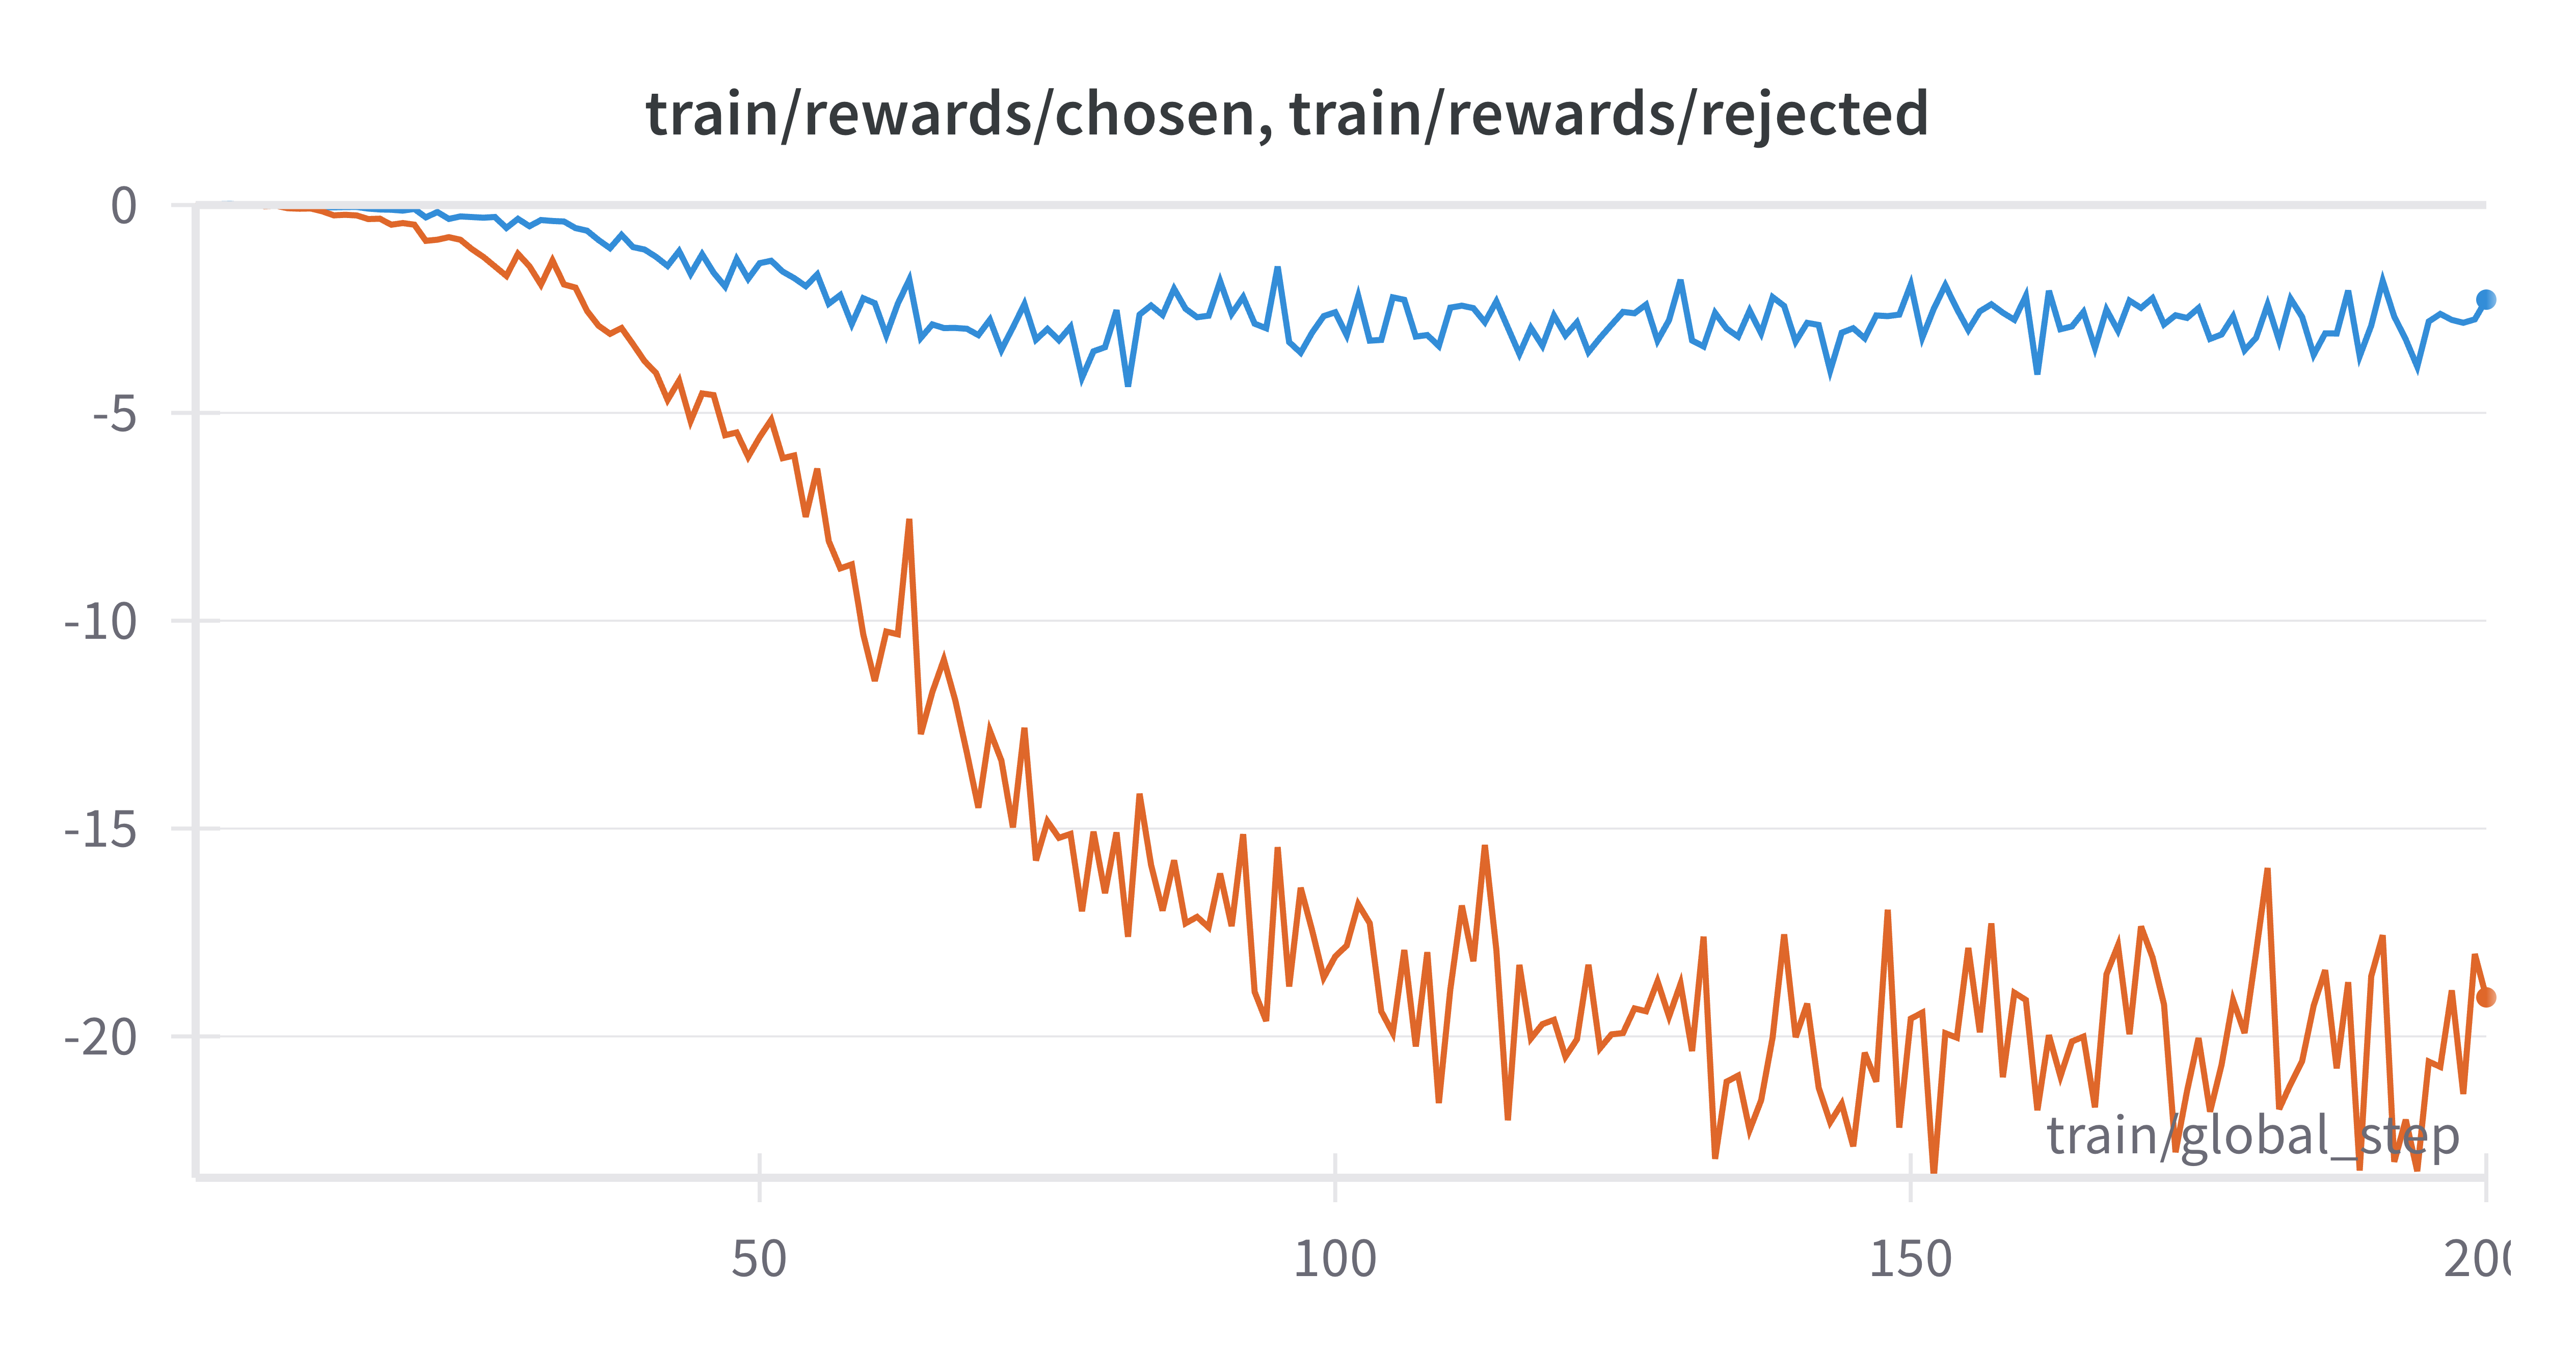

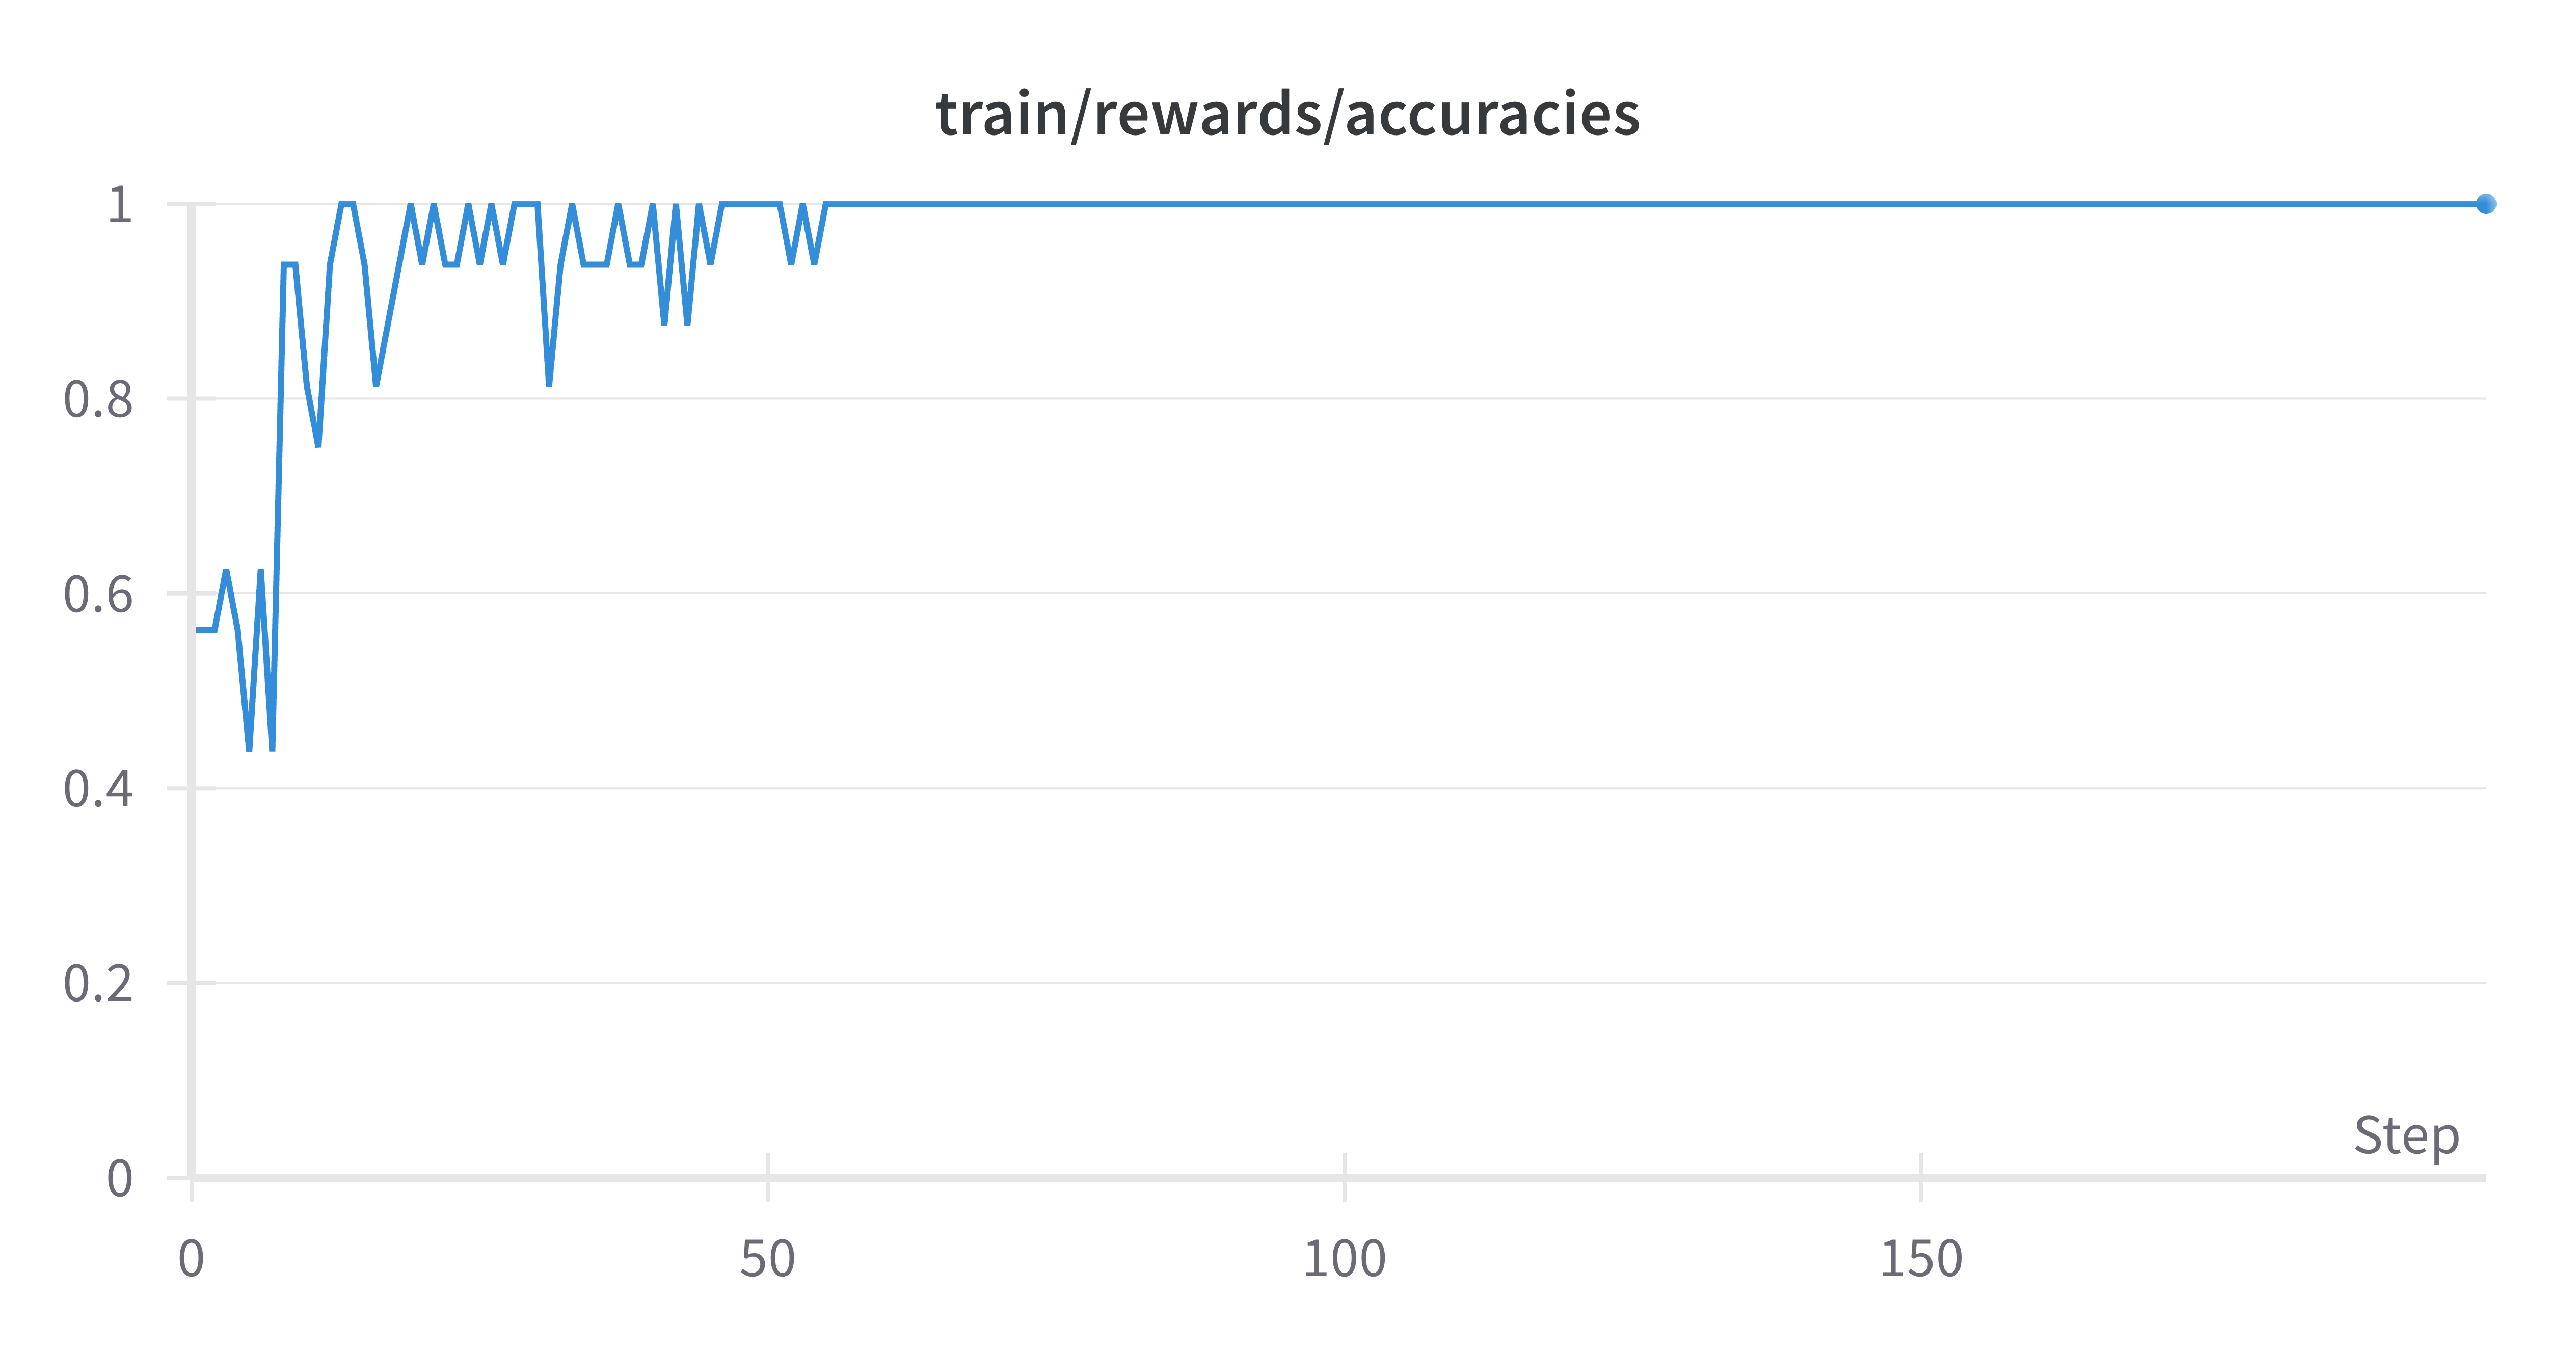

## Save and test model

In [28]:
dpo_trainer.model.save_pretrained("final_ckpt")

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [29]:
tokenizer.save_pretrained("final_ckpt")

('final_ckpt/tokenizer_config.json',
 'final_ckpt/special_tokens_map.json',
 'final_ckpt/tokenizer.json')

In [30]:
# Flush memory
del dpo_trainer, model, ref_model
gc.collect()
torch.cuda.empty_cache()

In [31]:
# Reload model in FP16 (instead of NF4)
base_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Meta-Llama-3-8B-Instruct",
    return_dict=True,
    torch_dtype=torch.float16,
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [32]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")
tokenizer.chat_template = chat_template

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [33]:
# Merge base model with the adapter
model = PeftModel.from_pretrained(base_model, "final_ckpt")
model = model.merge_and_unload()

# Save model and tokenizer
model.save_pretrained(new_model)
tokenizer.save_pretrained(new_model)

('BrevDPOLlama-3-8B/tokenizer_config.json',
 'BrevDPOLlama-3-8B/special_tokens_map.json',
 'BrevDPOLlama-3-8B/tokenizer.json')

In [34]:
# Create pipeline
pipeline = transformers.pipeline(
    "text-generation",
    model=new_model,
    tokenizer=tokenizer
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [35]:
# Format prompt
message = [
    {"role": "system", "content": "You are a helpful assistant chatbot that provides concise answers."},
    {"role": "user", "content": "What are GPUs and why would I use them for machine learning tasks?"}
]
tokenizer = AutoTokenizer.from_pretrained(new_model)
prompt = tokenizer.apply_chat_template(message, add_generation_prompt=True, tokenize=False)

# Generate text
sequences = pipeline(
    prompt,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
    num_return_sequences=1,
    max_length=200,
)
print(sequences[0]['generated_text'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a helpful assistant chatbot that provides concise answers.<|eot_id|><|start_header_id|>user<|end_header_id|>

What are GPUs and why would I use them for machine learning tasks?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

GPUs (Graphics Processing Units) are specialized computer chips designed for parallel processing, making them ideal for accelerating tasks that require numerous calculations, such as:

1. Graphics rendering
2. Scientific simulations
3. Data processing and machine learning

For machine learning tasks, GPUs offer significant benefits:

1. Faster training times: GPUs can process vast amounts of data in parallel, reducing training times by 10-100x or more.
2. Increased model complexity: GPUs enable you to train more complex models with larger datasets, leading to better accuracy and performance.
3. Scalability: GPUs can be easily scaled up or down depending on the task's requirements, making t

## Inference with NVIDIA NeMo Framework

Running text generation within the framework is also possible with running a Python script. Note that is more for testing and validation, not a full-fledged  deployment solution like NVIDIA NIM.

In [ ]:
# Check that the LORA model file exists
!ls -l ./results/Meta-llama3.1-8B-Instruct-titlegen/checkpoints

In the code snippet below, the following configurations are worth noting - 

1. `model.restore_from_path` to the path for the Meta-Llama-3.1-8B-Instruct.nemo file.
2. `model.peft.restore_from_path` to the path for the PEFT checkpoint that was created in the fine-tuning run in the last step.
3. `model.test_ds.file_names` to the path of the preprocessed test file.

In [ ]:
# Create a smaller test subset for a quick eval demonstration.
!head -n 128 ./curated-data/law-qa-test_preprocessed.jsonl > ./curated-data/law-qa-test_preprocessed-n128.jsonl

%%bash
MODEL="./llama-3_1-8b-instruct-nemo_v1.0/llama3_1_8b_instruct.nemo"

TEST_DS="[./curated-data/law-qa-test_preprocessed-n128.jsonl]" # Smaller test split
# TEST_DS="[./curated-data/law-qa-test_preprocessed.jsonl]" # Full test set
TEST_NAMES="[law]"

TP_SIZE=1
PP_SIZE=1

# This is where your LoRA checkpoint was saved
PATH_TO_TRAINED_MODEL="./results/Meta-llama3.1-8B-Instruct-titlegen/checkpoints/megatron_gpt_peft_lora_tuning.nemo"

# The generation run will save the generated outputs over the test dataset in a file prefixed like so
OUTPUT_PREFIX="law_titlegen_lora"

python /opt/NeMo/examples/nlp/language_modeling/tuning/megatron_gpt_generate.py \
    model.restore_from_path=${MODEL} \
    model.peft.restore_from_path=${PATH_TO_TRAINED_MODEL} \
    trainer.devices=1 \
    trainer.num_nodes=1 \
    model.data.test_ds.file_names=${TEST_DS} \
    model.data.test_ds.names=${TEST_NAMES} \
    model.data.test_ds.global_batch_size=32 \
    model.data.test_ds.micro_batch_size=1 \
    model.data.test_ds.tokens_to_generate=50 \
    model.tensor_model_parallel_size=${TP_SIZE} \
    model.pipeline_model_parallel_size=${PP_SIZE} \
    inference.greedy=True  \
    model.data.test_ds.output_file_path_prefix=${OUTPUT_PREFIX} \
    model.data.test_ds.write_predictions_to_file=True \
    model.data.test_ds.add_bos=False \
    model.data.test_ds.add_eos=True \
    model.data.test_ds.add_sep=False \
    model.data.test_ds.label_key="output" \
    model.data.test_ds.prompt_template="\{input\}\ \{output\}"

# Accelerated Inference with NVIDIA NIM

Now that we've trained our AI model on our specified dataset, lets go ahead and deploy them with NVIDIA NIM. NIM's let you deploy multiple LoRA adapters and supports the .nemo and Hugging Face model formats. To start, we must download the NIM from NGC and get it up and running with the LoRa's that we've trained.

In [ ]:
%%bash

wget https://raw.githubusercontent.com/brevdev/notebooks/main/assets/setup-nim.sh -O setup-nim
chmod +x setup-nim
export NGC_API_KEY=
./setup-nim

## Check available LoRA models

Once the NIM server is up and running, check the available models as follows:

In [ ]:
import requests
import json

url = 'http://0.0.0.0:8000/v1/models'

response = requests.get(url)
data = response.json()

print(json.dumps(data, indent=4))

This will return all the models available for inference by NIM. In this case, it will return the base model, as well as the LoRA adapters that were provided during NIM deployment - `llama3.1-8b-law-titlegen`.

---
## Inference

Inference can be performed by sending POST requests to the `/completions` endpoint.

A few things to note:
* The `model` parameter in the payload specifies the model that the request will be directed to. This can be the base model `meta/llama3.1-8b-instruct`, or any of the LoRA models, such as `llama3.1-8b-law-titlegen`.
* `max_tokens` parameter specifies the maximum number of tokens to generate. At any point, the cumulative number of input prompt tokens and specified number of output tokens to generate should not exceed the model's maximum context limit. For llama3-8b-instruct, the context length supported is 8192 tokens.

Following code snippets show how it's possible to send requests belonging to different LoRAs (or tasks). NIM dynamically loads the LoRA adapters and serves the requests. It also internally handles the batching of requests belonging to different LoRAs to allow better performance and more efficient of compute.

In [ ]:
url = 'http://0.0.0.0:8000/v1/completions'
headers = {
    'accept': 'application/json',
    'Content-Type': 'application/json'
}

# Example from the test set
prompt="Generate a concise, engaging title for the following legal question on an internet forum. The title should be legally relevant, capture key aspects of the issue, and entice readers to learn more. \nQUESTION: In order to be sued in a particular jurisdiction, say New York, a company must have a minimal business presence in the jurisdiction. What constitutes such a presence? Suppose the company engaged a New York-based Plaintiff, and its representatives signed the contract with the Plaintiff in New York City. Does this satisfy the minimum presence rule? Suppose, instead, the plaintiff and contract signing were in New Jersey, but the company hired a law firm with offices in New York City. Does this qualify? \nTITLE: "
data = {
    "model": "llama3.1-8b-law-titlegen",
    "prompt": prompt,
    "max_tokens": 50
}

response = requests.post(url, headers=headers, json=data)
response_data = response.json()

print(json.dumps(response_data, indent=4))